In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  #  Needed for optimizer

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
from skimage import measure  #  For largest component postprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
train_img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
train_mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"


In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)  # [B, H, W]
    target = target.long()            # [B, H, W]

    intersection = ((pred == 1) & (target == 1)).float().sum((1, 2))
    union = (pred == 1).float().sum((1, 2)) + (target == 1).float().sum((1, 2))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def jaccard_index(pred, target, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)
    target = target.long()

    intersection = ((pred == 1) & (target == 1)).float().sum((1, 2))
    union = ((pred == 1) | (target == 1)).float().sum((1, 2))
    return ((intersection + smooth) / (union + smooth)).mean().item()

class ISIC2017SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))

        # Binarize mask: make sure values are 0 or 1
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].long()  # [H, W]

        return img, mask  # [3,H,W], [H,W]

    def __len__(self):
        return len(self.image_paths)
transform = A.Compose([
    A.Resize(288, 288),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
image_ids = sorted([f[:-4] for f in os.listdir(train_img_dir) if f.endswith(".jpg")])
image_paths = [os.path.join(train_img_dir, f"{i}.jpg") for i in image_ids]
mask_paths = [os.path.join(train_mask_dir, f"{i}_segmentation.png") for i in image_ids]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = ISIC2017SegmentationDataset(train_imgs, train_masks, transform)
val_dataset = ISIC2017SegmentationDataset(val_imgs, val_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)



In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # [B, 2, H, W]
        preds = probs[:, 1, :, :]             # foreground class
        targets = (targets == 1).float()      # [B, H, W]
        intersection = (preds * targets).sum(dim=(1, 2))
        union = preds.sum(dim=(1, 2)) + targets.sum(dim=(1, 2))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()  # we minimize (1 - Dice)


def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    ce_loss = nn.CrossEntropyLoss()
    dice_loss = DiceLoss()

    def combined_loss(logits, targets):
        return 0.5 * ce_loss(logits, targets) + 0.5 * dice_loss(logits, targets)

    best_dice = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation ---
        model.eval()
        val_loss = 0
        dices, jaccards = [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = combined_loss(outputs, masks)
                val_loss += loss.item()
                dices.append(dice_coefficient(outputs, masks))
                jaccards.append(jaccard_index(outputs, masks))

        avg_dice = np.mean(dices)
        avg_jaccard = np.mean(jaccards)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f} | Dice: {avg_dice:.4f} | Jaccard: {avg_jaccard:.4f}")

        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "best_model.pth")
            print(" Best model saved!")

        scheduler.step()


with TTA

# SEGNET

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = SegNet(in_channels=3, out_channels=2)
train_model(model, train_loader, val_loader, num_epochs=10, device='cuda')


[Epoch 1/10] Training: 100%|██████████| 400/400 [02:17<00:00,  2.91it/s]


[Epoch 1] Train Loss: 0.5394 | Val Loss: 0.4623 | Dice: 0.6026 | Jaccard: 0.4938
 Best model saved!


[Epoch 2/10] Training: 100%|██████████| 400/400 [02:12<00:00,  3.01it/s]


[Epoch 2] Train Loss: 0.4461 | Val Loss: 0.4315 | Dice: 0.6139 | Jaccard: 0.5045
 Best model saved!


[Epoch 3/10] Training: 100%|██████████| 400/400 [02:12<00:00,  3.01it/s]


[Epoch 3] Train Loss: 0.4313 | Val Loss: 0.4183 | Dice: 0.6255 | Jaccard: 0.5166
 Best model saved!


[Epoch 4/10] Training: 100%|██████████| 400/400 [02:18<00:00,  2.88it/s]


[Epoch 4] Train Loss: 0.4213 | Val Loss: 0.4118 | Dice: 0.6255 | Jaccard: 0.5153
 Best model saved!


[Epoch 5/10] Training: 100%|██████████| 400/400 [02:14<00:00,  2.97it/s]


[Epoch 5] Train Loss: 0.4157 | Val Loss: 0.4076 | Dice: 0.6317 | Jaccard: 0.5234
 Best model saved!


[Epoch 6/10] Training: 100%|██████████| 400/400 [02:18<00:00,  2.88it/s]


[Epoch 6] Train Loss: 0.4112 | Val Loss: 0.4045 | Dice: 0.6237 | Jaccard: 0.5151


[Epoch 7/10] Training: 100%|██████████| 400/400 [02:18<00:00,  2.89it/s]


[Epoch 7] Train Loss: 0.4089 | Val Loss: 0.4032 | Dice: 0.6331 | Jaccard: 0.5249
 Best model saved!


[Epoch 8/10] Training: 100%|██████████| 400/400 [02:15<00:00,  2.95it/s]


[Epoch 8] Train Loss: 0.4060 | Val Loss: 0.4011 | Dice: 0.6300 | Jaccard: 0.5211


[Epoch 9/10] Training: 100%|██████████| 400/400 [02:12<00:00,  3.02it/s]


[Epoch 9] Train Loss: 0.4052 | Val Loss: 0.4028 | Dice: 0.6361 | Jaccard: 0.5282
 Best model saved!


[Epoch 10/10] Training: 100%|██████████| 400/400 [02:05<00:00,  3.19it/s]


[Epoch 10] Train Loss: 0.4045 | Val Loss: 0.4026 | Dice: 0.6371 | Jaccard: 0.5293
 Best model saved!


  0%|          | 0/200 [00:00<?, ?it/s]

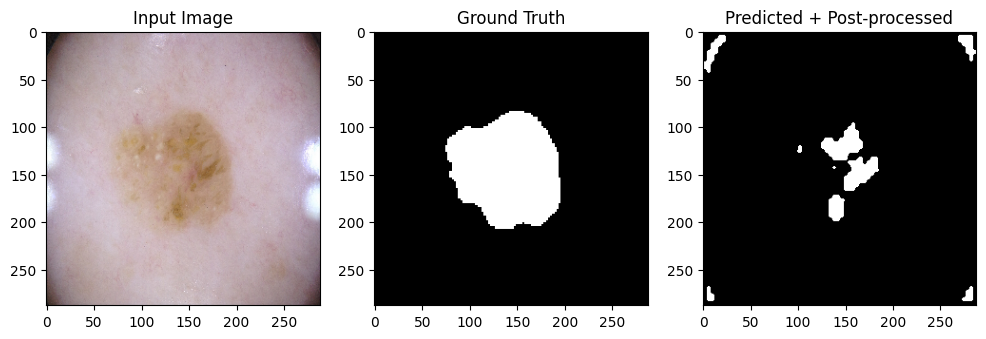

  0%|          | 1/200 [00:01<04:17,  1.29s/it]

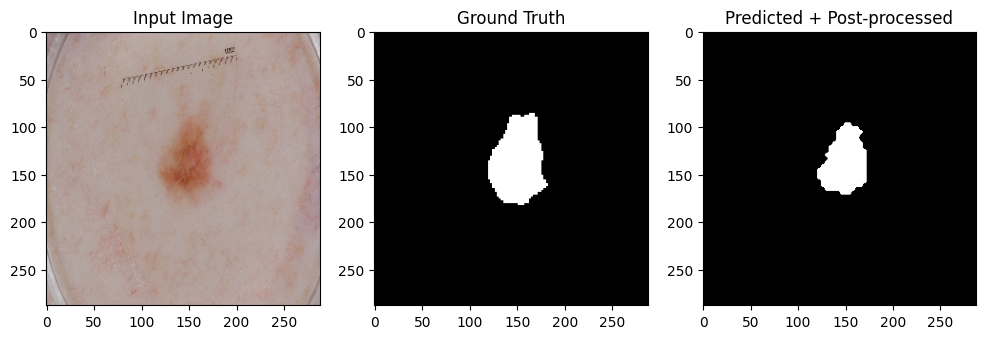

  1%|          | 2/200 [00:01<02:39,  1.24it/s]

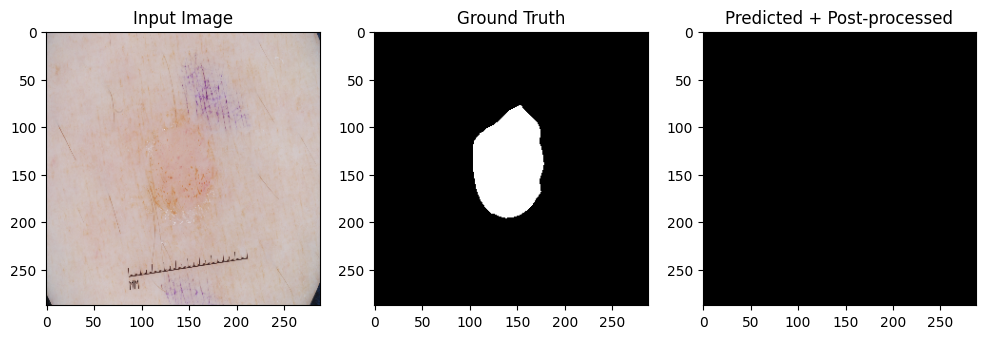

100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


Avg Dice: 0.6384
Avg Jaccard: 0.5311


In [ ]:
import cv2
import numpy as np

def post_process_mask(mask):
    # mask: [H, W], values 0 or 1
    mask = mask.astype(np.uint8) * 255

    # Remove small blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert back to binary
    return (mask > 127).astype(np.uint8)
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms.functional as TF

dice_scores = []
jaccard_scores = []

model.eval()

def apply_tta(model, image):
    """Performs Test-Time Augmentation (horizontal/vertical flips) and returns averaged prediction."""
    augmented_images = [
        image,
        TF.hflip(image),
        TF.vflip(image),
        TF.vflip(TF.hflip(image))
    ]

    preds = []
    for aug_img in augmented_images:
        aug_img = aug_img.unsqueeze(0).to("cuda")  # Add batch dim
        output = model(aug_img)
        if output.shape[1] > 1:
            output = torch.softmax(output, dim=1)
        else:
            output = torch.sigmoid(output)
        preds.append(output.cpu())

    # Reverse transforms
    preds[1] = TF.hflip(preds[1].squeeze(0))
    preds[2] = TF.vflip(preds[2].squeeze(0))
    preds[3] = TF.vflip(TF.hflip(preds[3].squeeze(0)))

    stacked = torch.stack([preds[0].squeeze(0), preds[1], preds[2], preds[3]])  # (4, C, H, W)
    avg_pred = stacked.mean(dim=0, keepdim=True)  # (1, C, H, W)
    return avg_pred

with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(val_loader)):
        image = image.to("cuda")  # (B, 3, H, W)
        mask = mask.to("cuda")    # (B, 1, H, W) or (B, H, W)

        for b in range(image.size(0)):
            img = image[b]
            gt = mask[b].squeeze().cpu().numpy()

            # TTA prediction
            output = apply_tta(model, img)  # (1, C, H, W)

            # Convert to label
            if output.shape[1] > 1:
                pred = torch.argmax(output, dim=1).squeeze(0).numpy()
            else:
                pred = (output.squeeze(0).squeeze(0) > 0.5).long().numpy()

            # Post-process
            pred_post = post_process_mask(pred)

            # Dice + Jaccard
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Visualize few
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# Final metrics
print(f"\nAvg Dice: {np.mean(dice_scores):.4f}")
print(f"Avg Jaccard: {np.mean(jaccard_scores):.4f}")


In [ ]:
!pip install segmentation-models-pytorch


# ENET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main_branch = nn.Conv2d(in_channels, out_channels - in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.ext_branch = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.PReLU()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)
        out = torch.cat((main, ext), dim=1)
        return self.relu(self.bn(out))


class ENetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation=1, downsample=False, dropout_prob=0.1):
        super().__init__()
        self.downsample = downsample
        self.in_channels = in_channels
        self.out_channels = out_channels

        internal_channels = in_channels // 4

        self.conv1 = nn.Conv2d(in_channels, internal_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(internal_channels)
        self.prelu1 = nn.PReLU()

        if downsample:
            self.conv2 = nn.Conv2d(internal_channels, internal_channels, kernel_size=kernel_size,
                                   stride=2, padding=padding, dilation=dilation, bias=False)
        else:
            self.conv2 = nn.Conv2d(internal_channels, internal_channels, kernel_size=kernel_size,
                                   padding=padding, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(internal_channels)
        self.prelu2 = nn.PReLU()

        self.conv3 = nn.Conv2d(internal_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=dropout_prob)

        self.match_channels = None
        if in_channels != out_channels or downsample:
            self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                            stride=2 if downsample else 1, bias=False)

        self.prelu_out = nn.PReLU()

    def forward(self, x):
        identity = x

        out = self.prelu1(self.bn1(self.conv1(x)))
        out = self.prelu2(self.bn2(self.conv2(out)))
        out = self.dropout(self.bn3(self.conv3(out)))

        if self.match_channels:
            identity = self.match_channels(identity)

        # Interpolate if shapes mismatch
        if out.shape != identity.shape:
            identity = F.interpolate(identity, size=out.shape[2:], mode='bilinear', align_corners=False)

        out += identity
        return self.prelu_out(out)


class ENet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.initial = InitialBlock(in_channels=3, out_channels=16)

        self.encoder1 = nn.Sequential(
            ENetBottleneck(16, 64, kernel_size=3, padding=1, downsample=True),
            ENetBottleneck(64, 64, kernel_size=3, padding=1),
            ENetBottleneck(64, 64, kernel_size=3, padding=2, dilation=2),
            ENetBottleneck(64, 64, kernel_size=3, padding=4, dilation=4),
            ENetBottleneck(64, 64, kernel_size=3, padding=8, dilation=8),
            ENetBottleneck(64, 64, kernel_size=3, padding=1)
        )

        self.encoder2 = nn.Sequential(
            ENetBottleneck(64, 128, kernel_size=3, padding=1, downsample=True),
            ENetBottleneck(128, 128, kernel_size=3, padding=1),
            ENetBottleneck(128, 128, kernel_size=3, padding=2, dilation=2),
            ENetBottleneck(128, 128, kernel_size=3, padding=4, dilation=4),
            ENetBottleneck(128, 128, kernel_size=3, padding=8, dilation=8),
            ENetBottleneck(128, 128, kernel_size=3, padding=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.PReLU(),

            nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.PReLU(),

            nn.ConvTranspose2d(16, num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.decoder(x)
        return x


In [ ]:
model = ENet(num_classes=2)
train_model(model, train_loader, val_loader, num_epochs=10, device='cuda')


[Epoch 1/10] Training: 100%|██████████| 400/400 [02:02<00:00,  3.26it/s]


[Epoch 1] Train Loss: 0.5775 | Val Loss: 0.5104 | Dice: 0.6159 | Jaccard: 0.4945
 Best model saved!


[Epoch 2/10] Training: 100%|██████████| 400/400 [02:00<00:00,  3.32it/s]


[Epoch 2] Train Loss: 0.4455 | Val Loss: 0.3693 | Dice: 0.7491 | Jaccard: 0.6370
 Best model saved!


[Epoch 3/10] Training: 100%|██████████| 400/400 [02:00<00:00,  3.33it/s]


[Epoch 3] Train Loss: 0.3679 | Val Loss: 0.3020 | Dice: 0.7698 | Jaccard: 0.6593
 Best model saved!


[Epoch 4/10] Training: 100%|██████████| 400/400 [02:02<00:00,  3.26it/s]


[Epoch 4] Train Loss: 0.3139 | Val Loss: 0.2516 | Dice: 0.8103 | Jaccard: 0.7159
 Best model saved!


[Epoch 5/10] Training: 100%|██████████| 400/400 [02:00<00:00,  3.31it/s]


[Epoch 5] Train Loss: 0.2786 | Val Loss: 0.2192 | Dice: 0.8337 | Jaccard: 0.7427
 Best model saved!


[Epoch 6/10] Training: 100%|██████████| 400/400 [01:59<00:00,  3.36it/s]


[Epoch 6] Train Loss: 0.2606 | Val Loss: 0.2127 | Dice: 0.8310 | Jaccard: 0.7413


[Epoch 7/10] Training: 100%|██████████| 400/400 [01:58<00:00,  3.38it/s]


[Epoch 7] Train Loss: 0.2431 | Val Loss: 0.2025 | Dice: 0.8369 | Jaccard: 0.7493
 Best model saved!


[Epoch 8/10] Training: 100%|██████████| 400/400 [01:59<00:00,  3.33it/s]


[Epoch 8] Train Loss: 0.2338 | Val Loss: 0.1823 | Dice: 0.8469 | Jaccard: 0.7630
 Best model saved!


[Epoch 9/10] Training: 100%|██████████| 400/400 [02:00<00:00,  3.31it/s]


[Epoch 9] Train Loss: 0.2277 | Val Loss: 0.1761 | Dice: 0.8539 | Jaccard: 0.7696
 Best model saved!


[Epoch 10/10] Training: 100%|██████████| 400/400 [02:01<00:00,  3.28it/s]


[Epoch 10] Train Loss: 0.2273 | Val Loss: 0.1714 | Dice: 0.8548 | Jaccard: 0.7700
 Best model saved!


  0%|          | 0/200 [00:00<?, ?it/s]

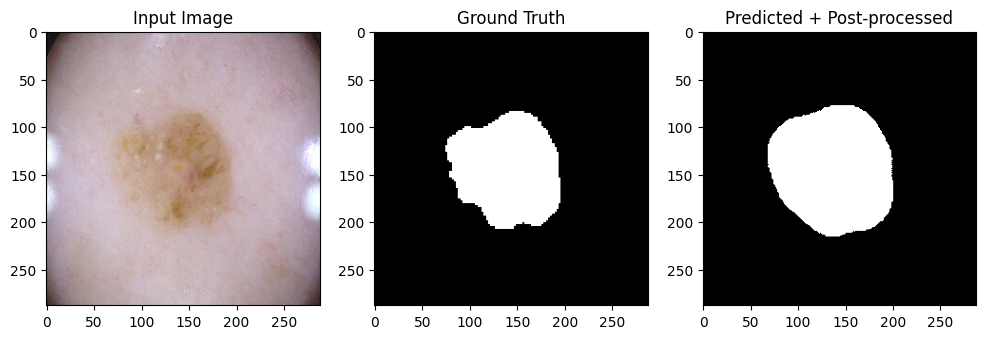

  0%|          | 1/200 [00:01<03:42,  1.12s/it]

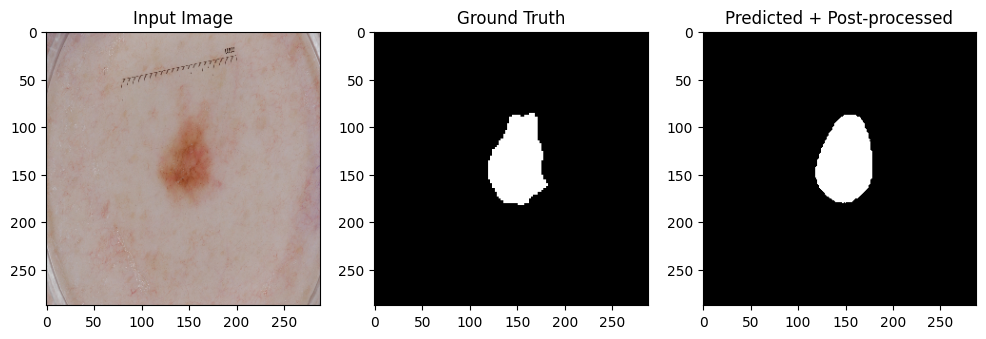

  1%|          | 2/200 [00:01<02:27,  1.34it/s]

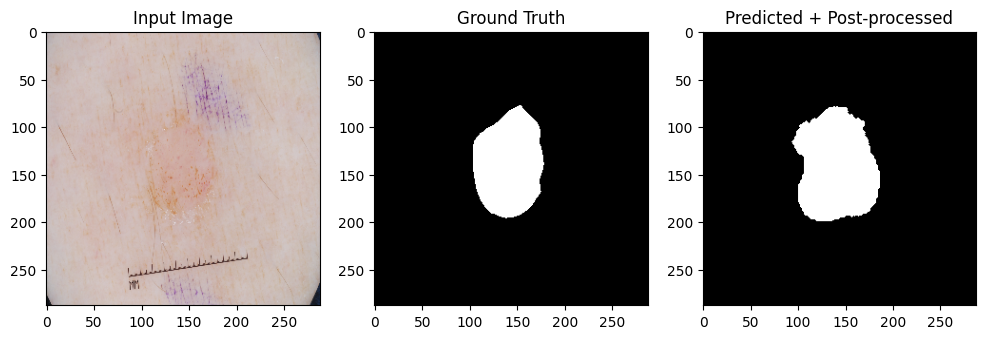

100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


Avg Dice: 0.8583
Avg Jaccard: 0.7762


In [ ]:
import cv2
import numpy as np

def post_process_mask(mask):
    # mask: [H, W], values 0 or 1
    mask = mask.astype(np.uint8) * 255

    # Remove small blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert back to binary
    return (mask > 127).astype(np.uint8)
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms.functional as TF

dice_scores = []
jaccard_scores = []

model.eval()

def apply_tta(model, image):
    """Performs Test-Time Augmentation (horizontal/vertical flips) and returns averaged prediction."""
    augmented_images = [
        image,
        TF.hflip(image),
        TF.vflip(image),
        TF.vflip(TF.hflip(image))
    ]

    preds = []
    for aug_img in augmented_images:
        aug_img = aug_img.unsqueeze(0).to("cuda")  # Add batch dim
        output = model(aug_img)
        if output.shape[1] > 1:
            output = torch.softmax(output, dim=1)
        else:
            output = torch.sigmoid(output)
        preds.append(output.cpu())

    # Reverse transforms
    preds[1] = TF.hflip(preds[1].squeeze(0))
    preds[2] = TF.vflip(preds[2].squeeze(0))
    preds[3] = TF.vflip(TF.hflip(preds[3].squeeze(0)))

    stacked = torch.stack([preds[0].squeeze(0), preds[1], preds[2], preds[3]])  # (4, C, H, W)
    avg_pred = stacked.mean(dim=0, keepdim=True)  # (1, C, H, W)
    return avg_pred

with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(val_loader)):
        image = image.to("cuda")  # (B, 3, H, W)
        mask = mask.to("cuda")    # (B, 1, H, W) or (B, H, W)

        for b in range(image.size(0)):
            img = image[b]
            gt = mask[b].squeeze().cpu().numpy()

            # TTA prediction
            output = apply_tta(model, img)  # (1, C, H, W)

            # Convert to label
            if output.shape[1] > 1:
                pred = torch.argmax(output, dim=1).squeeze(0).numpy()
            else:
                pred = (output.squeeze(0).squeeze(0) > 0.5).long().numpy()

            # Post-process
            pred_post = post_process_mask(pred)

            # Dice + Jaccard
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Visualize few
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# Final metrics
print(f"\nAvg Dice: {np.mean(dice_scores):.4f}")
print(f"Avg Jaccard: {np.mean(jaccard_scores):.4f}")


# UNET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetScratch(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNetScratch, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottom = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottom(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


model = UNetScratch(in_channels=3, out_channels=2)
train_model(model, train_loader, val_loader, num_epochs=10, device='cuda')


[Epoch 1/10] Training: 100%|██████████| 400/400 [02:17<00:00,  2.92it/s]


[Epoch 1] Train Loss: 0.4182 | Val Loss: 0.2994 | Dice: 0.7355 | Jaccard: 0.6227
 Best model saved!


[Epoch 2/10] Training: 100%|██████████| 400/400 [02:16<00:00,  2.92it/s]


[Epoch 2] Train Loss: 0.2942 | Val Loss: 0.2823 | Dice: 0.7463 | Jaccard: 0.6492
 Best model saved!


[Epoch 3/10] Training: 100%|██████████| 400/400 [02:15<00:00,  2.95it/s]


[Epoch 3] Train Loss: 0.2505 | Val Loss: 0.2474 | Dice: 0.7822 | Jaccard: 0.6945
 Best model saved!


[Epoch 4/10] Training: 100%|██████████| 400/400 [02:22<00:00,  2.82it/s]


[Epoch 4] Train Loss: 0.2234 | Val Loss: 0.2069 | Dice: 0.8101 | Jaccard: 0.7243
 Best model saved!


[Epoch 5/10] Training: 100%|██████████| 400/400 [02:16<00:00,  2.93it/s]


[Epoch 5] Train Loss: 0.2076 | Val Loss: 0.1875 | Dice: 0.8291 | Jaccard: 0.7477
 Best model saved!


[Epoch 6/10] Training: 100%|██████████| 400/400 [02:17<00:00,  2.90it/s]


[Epoch 6] Train Loss: 0.1859 | Val Loss: 0.1724 | Dice: 0.8404 | Jaccard: 0.7571
 Best model saved!


[Epoch 7/10] Training: 100%|██████████| 400/400 [02:21<00:00,  2.83it/s]


[Epoch 7] Train Loss: 0.1696 | Val Loss: 0.1802 | Dice: 0.8345 | Jaccard: 0.7586


[Epoch 8/10] Training: 100%|██████████| 400/400 [02:14<00:00,  2.98it/s]


[Epoch 8] Train Loss: 0.1617 | Val Loss: 0.1682 | Dice: 0.8468 | Jaccard: 0.7676
 Best model saved!


[Epoch 9/10] Training: 100%|██████████| 400/400 [02:16<00:00,  2.94it/s]


[Epoch 9] Train Loss: 0.1522 | Val Loss: 0.1532 | Dice: 0.8618 | Jaccard: 0.7858
 Best model saved!


[Epoch 10/10] Training: 100%|██████████| 400/400 [02:17<00:00,  2.90it/s]


[Epoch 10] Train Loss: 0.1461 | Val Loss: 0.1572 | Dice: 0.8575 | Jaccard: 0.7815


  0%|          | 0/200 [00:00<?, ?it/s]

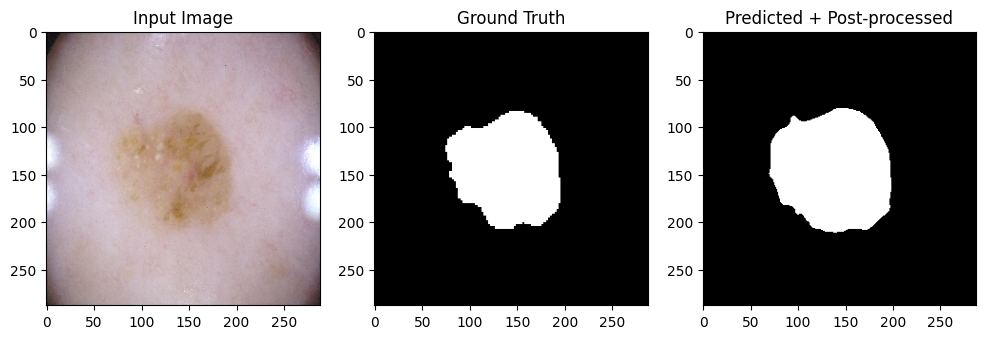

  0%|          | 1/200 [00:01<03:29,  1.05s/it]

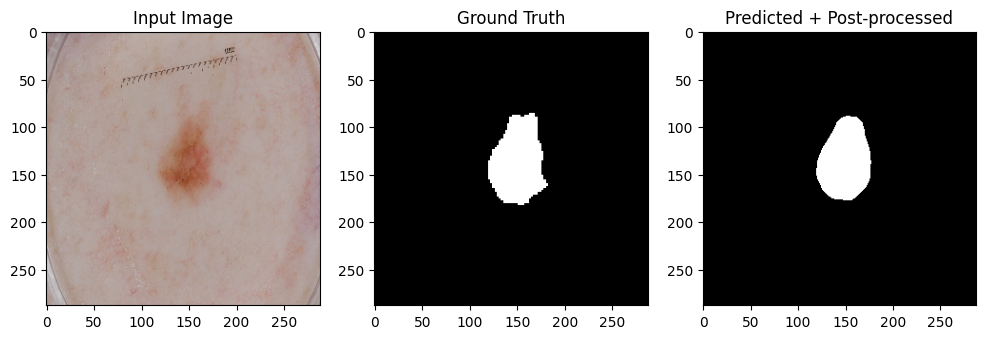

  1%|          | 2/200 [00:01<02:32,  1.30it/s]

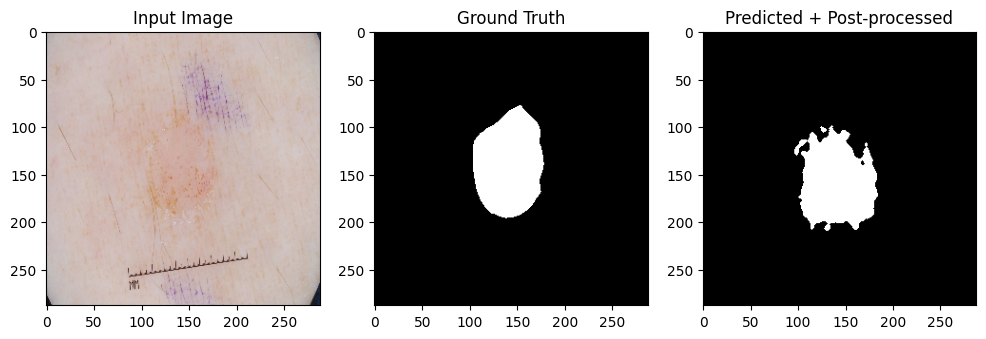

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


Avg Dice: 0.8593
Avg Jaccard: 0.7840


In [ ]:
import cv2
import numpy as np

def post_process_mask(mask):
    # mask: [H, W], values 0 or 1
    mask = mask.astype(np.uint8) * 255

    # Remove small blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert back to binary
    return (mask > 127).astype(np.uint8)
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms.functional as TF

dice_scores = []
jaccard_scores = []

model.eval()

def apply_tta(model, image):
    """Performs Test-Time Augmentation (horizontal/vertical flips) and returns averaged prediction."""
    augmented_images = [
        image,
        TF.hflip(image),
        TF.vflip(image),
        TF.vflip(TF.hflip(image))
    ]

    preds = []
    for aug_img in augmented_images:
        aug_img = aug_img.unsqueeze(0).to("cuda")  # Add batch dim
        output = model(aug_img)
        if output.shape[1] > 1:
            output = torch.softmax(output, dim=1)
        else:
            output = torch.sigmoid(output)
        preds.append(output.cpu())

    # Reverse transforms
    preds[1] = TF.hflip(preds[1].squeeze(0))
    preds[2] = TF.vflip(preds[2].squeeze(0))
    preds[3] = TF.vflip(TF.hflip(preds[3].squeeze(0)))

    stacked = torch.stack([preds[0].squeeze(0), preds[1], preds[2], preds[3]])  # (4, C, H, W)
    avg_pred = stacked.mean(dim=0, keepdim=True)  # (1, C, H, W)
    return avg_pred

with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(val_loader)):
        image = image.to("cuda")  # (B, 3, H, W)
        mask = mask.to("cuda")    # (B, 1, H, W) or (B, H, W)

        for b in range(image.size(0)):
            img = image[b]
            gt = mask[b].squeeze().cpu().numpy()

            # TTA prediction
            output = apply_tta(model, img)  # (1, C, H, W)

            # Convert to label
            if output.shape[1] > 1:
                pred = torch.argmax(output, dim=1).squeeze(0).numpy()
            else:
                pred = (output.squeeze(0).squeeze(0) > 0.5).long().numpy()

            # Post-process
            pred_post = post_process_mask(pred)

            # Dice + Jaccard
            intersection = np.logical_and(pred_post == 1, gt == 1).sum()
            union = np.logical_or(pred_post == 1, gt == 1).sum()
            dice = (2 * intersection) / (np.sum(pred_post) + np.sum(gt) + 1e-6)
            jaccard = intersection / (union + 1e-6)

            dice_scores.append(dice)
            jaccard_scores.append(jaccard)

            # Visualize few
            if idx < 3 and b == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                img_np = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_post, cmap='gray')
                plt.title("Predicted + Post-processed")
                plt.show()

# Final metrics
print(f"\nAvg Dice: {np.mean(dice_scores):.4f}")
print(f"Avg Jaccard: {np.mean(jaccard_scores):.4f}")
